In [2]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
import subprocess

# from keras.regularizers import L1L2
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Cropping2D

from src.data_preparation import load_data
from src.data_preparation.blocking_time_series_split import BlockingTimeSeriesSplit
from src.data_preparation import mdl_dataset
from src.data_preparation import mdl_dataset_prep

from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.modelling import mdl_history

# from src.modelling import model_autokeras
# from src.modelling import super_model_dl

from src.visualization import mdl_non_recursive
from src.visualization import mdl_ypred_PCA
from src.visualization import mdl_introspect

from src.utils import reload_config
from src.utils import tardisml_utils

from src.utils import save_name

In [3]:
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Reshape

In [4]:
def reshape_dim(xtrain, n_samples=50, timesteps=15, idx_samples=None):
    '''just for one feature for now
    
    # reshape (time serie, height, width) to (n_samples, timesteps, height, width, nfeature)
    3D to 5D

    Returns new array reshaped and random indexes used for sample selection
    
    n_samples      : int. number of sequence (batch?) of n frames (timesteps). number of samples
    timesteps      : int. number of frame in one sequence (temporal dimension)
    
    idx_samples    : array of indexes for sample selection. Default is None and random indexes are generated
    
    
    '''
    
    ntimes = xtrain.shape[0]
    height = xtrain.shape[1]
    width = xtrain.shape[2]
    
    new_data = np.zeros((n_samples, timesteps, height, width))
    if idx_samples is None:
        idx_samples = np.random.randint(0, ntimes-timesteps, size=n_samples)

    for ns in range(n_samples):
        new_data[ns] = xtrain[idx_samples[ns]:idx_samples[ns]+timesteps]
    
    # add one dimension for number of feature
    # (n_samples, timesteps, height, 1)
    return new_data[..., None], np.array(idx_samples)

In [5]:
def draw_loss(history, showfig=False, savefile=''):
    fig, ax1 = plt.subplots(1, 1, figsize=(12,4))

    epochs = range(len(history.history['loss']))
    
    ax1.plot(epochs, history.history['loss'], 'r', marker='.', label='Training')
    ax1.plot(epochs, history.history['val_loss'], 'b', linestyle="--", marker='.', label='Validation')

    ax1.set_ylabel('Loss')    
    ax1.set_xlabel('Epochs')

    
    plt.legend()
    plt.tight_layout()

    if savefile != '':
        odir = os.path.dirname(savefile)
        ofile = save_name.check(f"{odir}", os.path.basename(savefile))
        savefile = f'{odir}/{ofile}'
        plt.savefig(f"{savefile}")  # , facecolor='white')
        print(f'Saved as : {savefile}')

    if showfig:
        plt.show()

    plt.close() 
    

In [6]:
    
def scale_data(train_data, val_data, test_data):
    '''Scale between 0 and 1
    '''
    max_val = np.nanmax(train_data)  # .max()
    min_val = np.nanmin(train_data)  # .min()
    train_scaled = (train_data - min_val) / (max_val - min_val)
    val_scaled = (val_data - min_val) / (max_val - min_val)
    test_scaled = (test_data - min_val) / (max_val - min_val)
    return train_scaled, val_scaled, test_scaled

In [7]:
def scale_with_features(train_data, val_data, test_data):
    '''Features in last dimension
    '''
    
    train_out = train_data.copy()
    val_out = val_data.copy()
    test_out = test_data.copy()
    
    for nfeat in range(train_data.shape[-1]):
        train_out[...,nfeat], val_out[...,nfeat], test_out[...,nfeat] = scale_data(train_data[...,nfeat],
                                                                                   val_data[...,nfeat],
                                                                                   test_data[...,nfeat]
                                                                                  )
    
    return train_out, val_out, test_out
    
    

In [8]:
# ---------- MODEL --------------------------

def compile_ConvLSTM2d(nfeatures):
    '''
    '''
    
    seq = Sequential()

    seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                      input_shape=(None, 329, 450, nfeatures),
                       padding='same', return_sequences=True)) # , activation="relu"))
    seq.add(BatchNormalization())

    # 63
    seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                       padding='same', return_sequences=True))# , activation="relu"))
    seq.add(BatchNormalization())
    # 128
    seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                       padding='same', return_sequences=True))# , activation="relu"))
    seq.add(BatchNormalization())
    # 256
    seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                       padding='same', return_sequences=True)) #, activation="relu"))  # return_sequences=True
    seq.add(BatchNormalization())

    seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
                   activation='linear',
                   padding='same', data_format='channels_last'))
      # 'sigmoid',


    # seq.compile(loss='mse', optimizer=Adam(learning_rate=1e-4, clipnorm=1.))
    seq.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    
    return seq

In [9]:
def compile_Conv2D(nfeatures):
    '''
    '''
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), 
                     input_shape=(329, 450, nfeatures),
                     activation='relu', padding='same', data_format='channels_last'))

              
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
              
    model.add(Dense(1, activation='linear'))
              
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
              
    return model

In [10]:
from tensorflow.keras.layers import Cropping2D

In [11]:
def compile_Conv2D_encode_decode(nfeatures):
    
    model = Sequential()
    
    # Encoder
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(329, 450, nfeatures),
                     activation='relu', padding='same', data_format='channels_last'))
    model.add(MaxPooling2D((2,2), padding='same'))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,1), padding='same'))
    
    
    # Decoder
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,1)))
    
    model.add(Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same'))
    
    model.add(Cropping2D(cropping=((3, 4), (1, 1))))  # to correct output shape
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
              
    return model

# ------------------------------------------

In [12]:
file_config = '../config/config_to_jobs/config_C2D_no_bias_0wk.yaml'

rootdir = tardisml_utils.get_rootdir()
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

# -----------------------

Config file found: ../config/config_to_jobs/config_C2D_no_bias_0wk.yaml
PCA results in: /scratch/project_465000269/edelleo1/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/config_to_jobs/config_C2D_no_bias_0wk.yaml
Results in: /scratch/project_465000269/edelleo1/Leo/results/C2D_230308-171808
Folder created

Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/C2D_230308-171808/ml/
Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/C2D_230308-171808/figures/
Config file updated 'results_dir': ../config/config_to_jobs/config_C2D_no_bias_0wk.yaml
Config folders updated.
Config copied to: /scratch/project_465000269/edelleo1/Leo/results/C2D_230308-171808
Config file found: /scratch/project_465000269/edelleo1/Leo/results/C2D_230308-171808/config_C2D_no_bias_0wk.yaml
Default config file is now the copied following one:
/scratch/project_465000269/edelleo1/Leo/results/C2D_230308-171808/config_C2D_no_bias_0wk.yaml


In [13]:
from importlib import reload

In [14]:
reload(load_data)

<module 'src.data_preparation.load_data' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/load_data.py'>

In [15]:
# ---------------------------------------------------
#                 Loading data
# ---------------------------------------------------
print('Loading data...')
Xf, Xe, dsCo, dsFo, chrono, sia, mask = load_data.load_dataset_nc(file_config)

Loading data...
Loading sia...


In [15]:
# lat/lon
# np.repeat(Xf.longitude.data[None,...], 120, axis=0)

In [16]:
# data = (Xf, Xe, dsCo, dsFo, chrono)
Xe = Xe + Xf # trying with SIT assimilated instead of bias

# cap sea ice thickness at 0
# Xe = (Xe.where((0<Xe), 0)).where(np.isfinite(Xe))
              
              

In [17]:
# reverse latitude on sia
sia = sia.data[:, ::-1, :]

In [18]:
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(Xe.shape[0]) # , train_p=0.8, val_p=0.0)

In [19]:
# backwards in time (TARDIS proof)
Xtrain = Xf[ntest+nval:]
ytrain = Xe[ntest+nval:]
# ytest = Xe[100:150]  # [:ntest]

# not needed for now
Xval = Xf[ntest:ntest+nval]
yval = Xe[ntest:ntest+nval]

Xtest = Xf[:ntest]
ytest = Xe[:ntest]

In [20]:
ytrain.shape

(1959, 329, 450)

In [21]:
# -------------------- Build full dataset --------------------
# 4D
Xtrain_in = np.stack((Xtrain, dsCo['sisnthick'][ntest+nval:], dsCo['siconc'][ntest+nval:],
                     dsFo['2T_mean29d'][ntest+nval:], dsFo['MSL_mean29d'][ntest+nval:],
#                      sia[ntest+nval:],
                     np.repeat(Xf.latitude.data[None,...], ntrain, axis=0),
                     np.repeat(Xf.longitude.data[None,...], ntrain, axis=0),
                     np.repeat(mask.data[None,...], ntrain, axis=0) 
                     ), axis=-1)  
# stack on new axis
Xval_in = np.stack((Xval, dsCo['sisnthick'][ntest:ntest+nval], dsCo['siconc'][ntest:ntest+nval],
                   dsFo['2T_mean29d'][ntest:ntest+nval], dsFo['MSL_mean29d'][ntest:ntest+nval],
#                    sia[ntest:ntest+nval],
                   np.repeat(Xf.latitude.data[None,...], nval, axis=0),
                   np.repeat(Xf.longitude.data[None,...], nval, axis=0),
                   np.repeat(mask.data[None,...], nval, axis=0)
                   ), axis=-1)

Xtest_in = np.stack((Xtest, dsCo['sisnthick'][:ntest], dsCo['siconc'][:ntest],
                    dsFo['2T_mean29d'][:ntest], dsFo['MSL_mean29d'][:ntest], 
#                     sia[:ntest],
                    np.repeat(Xf.latitude.data[None,...], ntest, axis=0),
                    np.repeat(Xf.longitude.data[None,...], ntest, axis=0), 
                    np.repeat(mask.data[None,...], ntest, axis=0)  
                    ), axis=-1)

nfeatures = Xtrain_in.shape[-1]

# inputs = ['Xf', 'sisnthick', 'siconc', '2T', 'MLS', 'SIA', 'lat', 'lon']
inputs = ['Xf', 'sisnthick', 'siconc', '2T', 'MLS', 'lat', 'lon', 'mask land/ocean']
print(inputs)
              

['Xf', 'sisnthick', 'siconc', '2T', 'MLS', 'lat', 'lon', 'mask land/ocean']


In [22]:
# now we want to add history

# from shape : (1959, 329, 450, 8)  = (timeserie, width, length, features)
#     to (1959, timesteps, 329, 450, 8) = (timeserie, timesteps=history, width, length, features)

In [23]:
def ds_2D_history(X, H):
    '''For dataset for Conv2D
    
    from shape : (1959, 329, 450, 8)  = (timeserie, width, length, features)
    to (1959, timesteps, 329, 450, 8) = (timeserie, timesteps=history, width, length, features)
    
    X : data for training
    H : history, array of time index to add
    
    '''
    
    ntime = X.shape[0]
    ydim = X.shape[1] 
    xdim = X.shape[2]
    nfeat = X.shape[-1]

    
    # If need different timesteps (History)
    needfutur, needpast = 0, 0
    if max(H)>0:
        needfutur = max(H)
    if min(H)<0:
        needpast = abs(min(H))
                
    # Number of data
    n = ntime - needpast - needfutur
    nH = len(H)
    
    X2 = np.empty([n, nH, ydim, xdim, nfeat])
    
    
    for t in range(n):
        for i, ts in enumerate(H):
            X2[t, i] = X[needpast+t+ts]
    
    
    return X2

In [24]:
H = [0, 8, 16, 24]

In [25]:
Xtrain_in = ds_2D_history(Xtrain_in, H)
Xval_in = ds_2D_history(Xval_in, H)
Xtest_in = ds_2D_history(Xtest_in, H)

In [28]:
Xtrain_in.shape

(1935, 4, 329, 450, 8)

In [29]:
ytrain = ytrain[:-max(H)]
yval = yval[:-max(H)]
ytest = ytest[:-max(H)]

In [ ]:
# need to modify 'chrono'

In [30]:
# ------------- CLEAN NAN ---------------------

# indexes Nan
iNan_xtrain = np.isnan(Xtrain_in)
iNan_xval = np.isnan(Xval_in)
iNan_xtest = np.isnan(Xtest_in)
# iNan_yttest = np.isnan(yttest)

# remove Nan
nan_value = 0  # -999
Xtrain_in[iNan_xtrain] = nan_value
Xval_in[iNan_xval] = nan_value
Xtest_in[iNan_xtest] = nan_value 
# yttest[iNan_yttest] = nan_value 
              
ytrain.data[np.isnan(ytrain.data)] = nan_value
yval.data[np.isnan(yval.data)] = nan_value
ytest.data[np.isnan(ytest.data)] = nan_value
              

In [34]:
# --------------- SCALING - not sure it helps ------------------
# scale inputs
xtrain_sc, xval_sc, xtest_sc = scale_data(Xtrain_in, Xval_in, Xtest_in)

# scale ouputs
# yt_sc, yttest_sc = scale_data(ytrain.data, ytest.data)
# ---------------------------------

In [31]:
# scale each feature separately

xtrain_sc, xval_sc, xtest_sc = scale_with_features(Xtrain_in, Xval_in, Xtest_in)
# ---------------------------------

In [36]:
full_x = np.concatenate((xtrain_sc, xval_sc, xtest_sc))

In [37]:
full_x.shape

(2942, 4, 329, 450, 8)

In [37]:
# ---------- MODEL --------------------------

def compile_ConvLSTM2d_H(nfeatures, nH):
    '''
    format (timeserie, timesteps=history, width, length, features)
    
    '''
    
    seq = Sequential()

    # 32
    seq.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                      input_shape=(nH, 329, 450, nfeatures),
                       padding='same', return_sequences=True)) # , activation="relu"))
    seq.add(BatchNormalization())

    # 63
#     seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
#                        padding='same', return_sequences=True))# , activation="relu"))
#     seq.add(BatchNormalization())
#     # 128
#     seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
#                        padding='same', return_sequences=True))# , activation="relu"))
#     seq.add(BatchNormalization())
#     # 256
#     seq.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
#                        padding='same', return_sequences=True)) #, activation="relu"))  # return_sequences=True
#     seq.add(BatchNormalization())

    seq.add(MaxPooling3D(pool_size=(nH,1,1)))
    
    seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
                   activation='linear',
                   padding='same', data_format='channels_last'))
      # 'sigmoid',


    seq.add(Reshape((329,450)))
        
    # seq.compile(loss='mse', optimizer=Adam(learning_rate=1e-4, clipnorm=1.))
    seq.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    
    return seq

In [ ]:
# model Conv3D ?

# Dense 5D ?

In [40]:
# ---------- MODEL --------------------------


batch_size = 8 # 32  # default that I put
epochs = 1  # 50  # first try

# seq = compile_Conv2D(nfeatures=nfeatures)
# seq = compile_Conv2D_encode_decode(nfeatures=nfeatures)
seq = compile_ConvLSTM2d_H(nfeatures=nfeatures, nH=len(H))

seq.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_6 (ConvLSTM2D)  (None, 4, 329, 450, 16)   13888     
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 329, 450, 16)   64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 329, 450, 16)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 329, 450, 1)    433       
_________________________________________________________________
reshape_3 (Reshape)          (None, 329, 450)          0         
Total params: 14,385
Trainable params: 14,353
Non-trainable params: 32
_________________________________________________________________


In [ ]:
# --------------- TRAINING ------------------
history = seq.fit(xtrain_sc, ytrain.data, batch_size=batch_size, epochs=epochs, 
                  validation_data=(xval_sc, yval.data), verbose=1)
# history = seq.fit(xt_sc, yt_sc, batch_size=batch_size, epochs=epochs, validation_split=0.2)

2023-03-08 16:57:17.259645: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36669024000 exceeds 10% of free system memory.


166/242 [===================>..........] - ETA: 8:20 - loss: 0.4872

In [ ]:
# --------------- SAVE MODEL ------------------

oname = f'modelweights_Conv2D_b{batch_size}_e{epochs}'
ofolder = save_name.check(f"{conf.rootdir}{conf.ml_dir}", oname)
ofolder = f"{conf.rootdir}{conf.ml_dir}{oname}" 
            
seq.save_weights(ofolder)

In [79]:
# --------------- PREDICTION ------------------
# ypred = seq.predict(xttest)
# ypred = seq.predict(xtest_sc)
ypred = seq.predict(full_x)

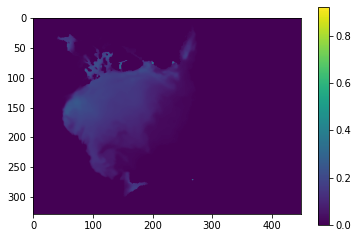

In [81]:
plt.imshow(xtest_sc[0,:,:,0])
plt.colorbar()

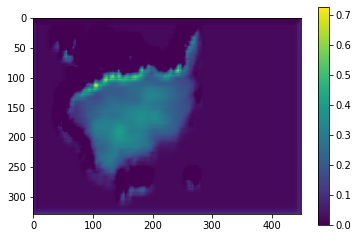

In [80]:
plt.imshow(ypred[0])
plt.colorbar()

In [83]:
np.nanmin(Xe[0])

-3.241154

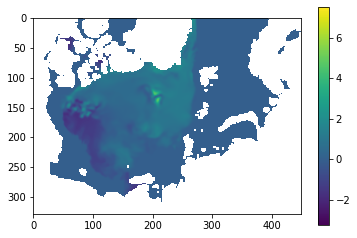

In [85]:
plt.imshow(Xe[0])# , vmin=0)
plt.colorbar()

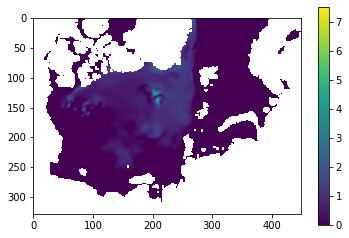

In [86]:
plt.imshow(Xe[0], vmin=0)
plt.colorbar()

In [ ]:
# --------------- SAVE PREDICTION ------------------
# to xarray
# to netcdf
odir = ''
ofile = f'ypred_Conv2D_epochs{epochs}.nc'

              
ypred_xr = xr.DataArray(data=ypred[:,:,:,0], 
                        dims=['time','y','x'], 
                        coords={'time':chrono[:ntest].squeeze(),'y':Xf.y,'x':Xf.x},
                        name='sit_pred').to_netcdf(ofile)

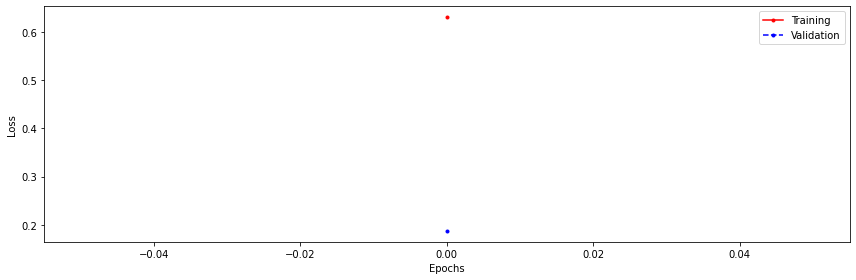

In [19]:
# --------------- PLOT ------------------
ofile = '/users/edelleo1/tardis/tardis-ml/pyroutine/Loss_Conv2D.png'
draw_loss(history, showfig=False, savefile=ofile)

In [ ]:
exit()